# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

- Представлена выгрузка в формате csv файла, без разделения на столбцы. 
- Предстоит провести предобработку данных (заполнить логичные пропуски, очистить от артефактов и выделяющихся значений).
- Добавить дополнительные данные (цена за метр, тип этажа, обработанная дата публикации).
- Найти зависимость цены от множества других факторов.
- Выделить центр Питера и сравнить значение во всем городе с центром.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [3]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

<p>Открыли файл с разделителем Tab, получили 22 столбца.</p>
<p>У нас есть стобцы с пропусками данных, предстоит выяснить в чем проблема и заполнить.</p>
<p>На данный момент в таблице представлены 4 типа данных, их ещё предстоит отобработать.</p>

### Шаг 2. Предобработка данных

У нас есть 5 столбцов, в которых нет пропусков и которые, по смыслу, хранят в себе целые значения. Сменили для них тип данных. В остальных столбцах нужно будет сначала либо заполнить пропуски, либо удалить (обосновав своё решение), либо оставить пропуски на месте.

<h4>Количество фотографий, цена продажи, общая площадь, количество комнат, этаж</h4>

In [4]:
data[['total_images','last_price','total_area','rooms','floor']]=data[['total_images','last_price','total_area','rooms','floor']].astype('int')

In [5]:
data[['total_images','last_price','total_area','rooms','floor']].describe()

,total_images,last_price,total_area,rooms,floor
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000
mean,9.858475,6.541549e+06,60.120511,2.070636,5.892358
std,5.682529,1.088701e+07,35.665822,1.078405,4.885249
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,4.000000
75%,14.000000,6.800000e+06,69.000000,3.000000,8.000000
max,50.000000,7.630000e+08,900.000000,19.000000,33.000000


<h4>Дата публикации</h4>

Приведём столбец с датой публикации к соответствующему типу.

In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null int64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aroun

Все нужные нам полные столбцы сменили свои типы. Проверим описание всех неполных колнок на содержание и соответствие типу данных по порядку. Начнем с высоты потолка.

<h4>Высота потолков</h4>

In [9]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [10]:
print('Процент объявлений без указания высоты потолков: {:.2%}'.format((data[data['ceiling_height'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания высоты потолков: 38.80%


Процент высокий, оставляем так.

In [11]:
data.query('ceiling_height>4 or ceiling_height<2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000,80,2018-11-06,3,4.15,3.0,44.2,2,NaN,...,12.2,NaN,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
355,17,3600000,55,2018-07-12,2,25.00,5.0,32.0,2,False,...,NaN,2.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.0
464,15,66571000,280,2015-06-11,6,5.20,8.0,159.5,7,NaN,...,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000,310,2018-10-12,5,5.30,3.0,190.0,3,NaN,...,63.0,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1053,13,550000,29,2018-02-01,1,5.00,3.0,NaN,1,False,...,NaN,NaN,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22336,19,9999000,92,2019-04-05,2,32.00,6.0,55.5,5,False,...,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
22494,7,91075000,491,2017-05-27,5,4.20,9.0,274.0,9,NaN,...,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
22590,16,6000000,55,2018-10-31,2,1.00,12.0,32.4,7,NaN,...,10.0,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
22869,0,15000000,25,2018-07-25,1,100.00,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Посмотрели на распределение всех значений высоты потолков и на список уникальных.  У нас есть 78 объявлений с нестандартной высотой (меньше 2 или больше 4), пока всё оставляю на месте, пропусков достаточно много и как их заполнить пока тоже не понятно.

In [12]:
data.groupby('floors_total')['ceiling_height'].mean()

floors_total
1.0      2.740000
2.0      3.006791
3.0      2.969474
4.0      2.986831
5.0      2.793191
6.0      3.120743
7.0      2.946960
8.0      2.856818
9.0      2.599093
10.0     2.685200
11.0     2.782385
12.0     2.640258
13.0     2.715470
14.0     2.731545
15.0     2.714844
16.0     2.747503
17.0     2.749145
18.0     2.704582
19.0     2.778731
20.0     2.756859
21.0     2.711692
22.0     2.731560
23.0     2.753776
24.0     2.851567
25.0     2.776597
26.0     2.709259
27.0     2.675556
28.0     2.594444
29.0     2.600000
33.0          NaN
34.0     2.650000
35.0     2.710000
36.0    14.850000
37.0     1.750000
52.0     2.650000
60.0     2.880000
Name: ceiling_height, dtype: float64

In [13]:
'''for i,j in zip(data.groupby('floors_total')['ceiling_height'].mean().index, data.groupby('floors_total')['ceiling_height'].mean().values):
    data['ceiling_height']=data[data['floors_total']==i]['ceiling_height'].fillna(j)
data['ceiling_height'].describe()'''

"for i,j in zip(data.groupby('floors_total')['ceiling_height'].mean().index, data.groupby('floors_total')['ceiling_height'].mean().values):\n    data['ceiling_height']=data[data['floors_total']==i]['ceiling_height'].fillna(j)\ndata['ceiling_height'].describe()"

In [14]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [15]:
data['ceiling_height'].median()

2.65

In [16]:
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())

In [17]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

После консультации было решено заполнить пропуски медианой.

<h4>Всего этажей в доме</h4>

In [18]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [19]:
print('Процент объявлений без указания этажности дома: {:.2%}'.format((data[data['floors_total'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания этажности дома: 0.36%


Меньше 1% - можно спокойно удалить.

In [20]:
data.drop(data[data['floors_total'].isnull()==True].index, inplace = True) 
data=data.reset_index(drop=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23613 entries, 0 to 23612
Data columns (total 22 columns):
total_images            23613 non-null int64
last_price              23613 non-null int64
total_area              23613 non-null int64
first_day_exposition    23613 non-null datetime64[ns]
rooms                   23613 non-null int64
ceiling_height          23613 non-null float64
floors_total            23613 non-null float64
living_area             21743 non-null float64
floor                   23613 non-null int64
is_apartment            2775 non-null object
studio                  23613 non-null bool
open_plan               23613 non-null bool
kitchen_area            21382 non-null float64
balcony                 12133 non-null float64
locality_name           23565 non-null object
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        18105 non-null float64
parks_nearest           8045 non-null float64
ponds_aroun

<h4>Жилая площадь</h4>

In [21]:
data['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [22]:
data.sort_values('living_area')['living_area'].value_counts()

18.000000    882
17.000000    674
30.000000    598
16.000000    484
20.000000    481
            ... 
16.740000      1
13.820000      1
33.570000      1
21.530000      1
44.100002      1
Name: living_area, Length: 1769, dtype: int64

In [23]:
print('Процент объявлений без указания жилой площади: {:.2%}'.format((data[data['living_area'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания жилой площади: 7.92%


Более 1%, удалять нельзя. Найдем средний коэффициент отношения общей площади к жилой.

In [24]:
total_to_living=((data[data['living_area'].isnull()==False]['total_area'])/(data[data['living_area'].isnull()==False]['living_area'])).median()
total_to_living

1.75

In [25]:
data['living_area']=data['living_area'].fillna((data.loc[data['living_area'].isnull(),'total_area'])/(total_to_living))

In [26]:
data['living_area'].describe()

count    23613.000000
mean        34.595627
std         22.369098
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64

In [27]:
data['living_area']=data['living_area'].astype('int')

In [28]:
data.sort_values('living_area')['living_area'].value_counts()

17     1646
18     1568
30     1097
16     1023
28      867
       ... 
230       1
199       1
279       1
239       1
255       1
Name: living_area, Length: 218, dtype: int64

Округлили все значения жилой площади, т.к. чаще всего встречаются целые значения, на выходе получилось 218 разных вариантов, вместо 1782.

<h4>Апартаменты</h4>

In [29]:
data['is_apartment'].describe()

count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object

In [30]:
data['is_apartment']=data['is_apartment'].fillna(False)

In [31]:
data['is_apartment'].value_counts()

False    23563
True        50
Name: is_apartment, dtype: int64

In [32]:
data['is_apartment']=data['is_apartment'].astype('bool')

Всем объявлениям, где не была указана принадлежность к апартаментам, было присвоено значение False.

<h4>Студия</h4>

In [33]:
data['studio'].describe()

count     23613
unique        2
top       False
freq      23467
Name: studio, dtype: object

<h4>Свободная планировка</h4>

In [34]:
data['open_plan'].describe()

count     23613
unique        2
top       False
freq      23546
Name: open_plan, dtype: object

Столбцы "Студия" и "Свобдная планировка" имеют нужный тип и полностю заполнены.

<h4>Площадь кухни</h4>

In [35]:
data['kitchen_area'].describe()

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [36]:
data['kitchen_area'].value_counts()

6.00      1300
10.00     1262
8.00      1110
9.00      1100
7.00      1062
          ... 
31.30        1
18.93        1
11.43        1
112.00       1
54.20        1
Name: kitchen_area, Length: 966, dtype: int64

In [37]:
print('Процент объявлений без указания площади кухни: {:.2%}'.format((data[data['kitchen_area'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания площади кухни: 9.45%


Процент достаточно большой, найдём средний коэффициент зависимости площади кухни от общей площади.

In [38]:
total_to_kitchen=((data[data['kitchen_area'].isnull()==False]['total_area'])/(data[data['kitchen_area'].isnull()==False]['kitchen_area'])).median()
total_to_kitchen

5.777777777777778

In [39]:
data['kitchen_area']=data['kitchen_area'].fillna((data.loc[data['kitchen_area'].isnull(),'total_area'])/(total_to_kitchen))

In [40]:
data['kitchen_area'].describe()

count    23613.000000
mean        10.489350
std          6.033049
min          1.300000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Все значения заполнены, но изменился тип на вещественный, вернём к целому.

In [41]:
data['kitchen_area']=data['kitchen_area'].astype('int')

In [42]:
data['kitchen_area'].value_counts()

8      3093
6      2953
10     2837
7      2468
9      2349
       ... 
47        1
107       1
87        1
66        1
52        1
Name: kitchen_area, Length: 76, dtype: int64

Показатели по данным не пострадали, всё в порядке.

<h4>Балкон</h4>

In [43]:
data['balcony'].describe()

count    12133.000000
mean         1.154208
std          1.071022
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

In [44]:
data['balcony']=data['balcony'].fillna(0)

In [45]:
data['balcony'].describe()

count    23613.000000
mean         0.593063
std          0.960307
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

In [46]:
data['balcony']=data['balcony'].astype('int')

Пропущенные значения балкона заполнили нулям и изменили тип столбца.

<h4>Населенный пункт</h4>

In [47]:
data['locality_name'].describe()

count               23565
unique                364
top       Санкт-Петербург
freq                15651
Name: locality_name, dtype: object

In [48]:
print('Процент объявлений без наименования населенного пункта: {:.2%}'.format((data[data['locality_name'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без наименования населенного пункта: 0.20%


Меньше 1% - можно спокойно удалить.

In [49]:
data.drop(data[data['locality_name'].isnull()==True].index, inplace = True) 
data=data.reset_index(drop=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null int64
total_area              23565 non-null int64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null int64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null int64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000  

<h4>Расстояние до аэропорта</h4>

In [50]:
data['airports_nearest'].describe()

count    18041.000000
mean     28797.082701
std      12632.499735
min          0.000000
25%      18565.000000
50%      26757.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [51]:
print('Процент объявлений без указания расстояния до аэропорта: {:.2%}'.format((data[data['airports_nearest'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания расстояния до аэропорта: 23.44%


Каждое 4 объявление остаётся без информации о расстояии до аэропорта.

<h4>Расстояние до центра города</h4>

In [52]:
data['cityCenters_nearest'].describe()

count    18064.000000
mean     14192.656056
std       8613.348153
min        181.000000
25%       9238.000000
50%      13096.500000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [53]:
print('Процент объявлений без указания расстояния до центра города: {:.2%}'.format((data[data['cityCenters_nearest'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания расстояния до центра города: 23.34%


Каждое 4 объявление остаётся без информации о расстояии до центра города.

<h4>Количество парков в радиусе 3 км</h4>

In [54]:
data['parks_around3000'].describe()

count    18065.000000
mean         0.611569
std          0.802088
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [55]:
print('Процент объявлений без указания количества парков в радиусе 3 км: {:.2%}'.format((data[data['parks_around3000'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания количества парков в радиусе 3 км: 23.34%


Каждое 4 объявление остаётся без информации о количестве парков в радиусе 3 км.

<h4>Расстояние до ближайшего парка</h4>

In [56]:
data['parks_nearest'].describe()

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [57]:
print('Процент объявлений без указания расстояния до парка: {:.2%}'.format((data[data['parks_nearest'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания расстояния до парка: 65.92%


Больше половины объявлений остаются без указания расстояния до ближайшего парка.

<h4>Количество прудов в радиусе 3 км</h4>

In [58]:
data['ponds_around3000'].describe()

count    18065.000000
mean         0.769499
std          0.938669
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [59]:
print('Процент объявлений без указания количества прудов в радиусе 3 км: {:.2%}'.format((data[data['ponds_around3000'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания количества прудов в радиусе 3 км: 23.34%


Каждое 4 объявление остаётся без информации о количестве прудов в радиусе 3 км.

<h4>Расстояние до ближайшего пруда</h4>

In [60]:
data['ponds_nearest'].describe()

count    9036.000000
mean      518.289509
std       278.009558
min        13.000000
25%       293.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [61]:
print('Процент объявлений без указания расстояния до парка: {:.2%}'.format((data[data['ponds_nearest'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания расстояния до парка: 61.65%


Больше половины объявлений остаются без указания расстояния до ближайшего пруда.

<h4>Сколько дней продавали</h4>

In [62]:
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [63]:
print('Процент объявлений без указания продолжительности продажи: {:.2%}'.format((data[data['days_exposition'].isnull()==True]['total_images'].count())/(data['total_images'].count())))

Процент объявлений без указания продолжительности продажи: 13.46%


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null int64
total_area              23565 non-null int64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null int64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null int64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000  

Просмотрели все столбцы, где было всё очевидно - заполнли пропуски и изменили тип данных. Некоторые пропуски было решено удалить.

На данный момент в таблице ещё остались строки с пропусками.

### Шаг 3. Посчитайте и добавьте в таблицу

<h4>Цена квадратного метра</h4>

In [65]:
data['metr_price']=data['last_price']/data['total_area']
data['metr_price']=data['metr_price'].astype('int')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price
0,20,13000000,108,2019-03-07,3,2.70,16.0,51,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370
1,7,3350000,40,2018-12-04,1,2.65,11.0,18,1,False,...,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,83750
2,10,5196000,56,2015-08-20,2,2.65,5.0,34,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785
3,0,64900000,159,2015-07-24,3,2.65,14.0,90,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176
4,2,10000000,100,2018-06-19,2,3.03,14.0,32,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000


Добавили стобец с ценой квадратного метра, для дальнейшего анализа сразу перевели его к целому типу.

<h4>Дата публикации в формате "день недели-месяц-год"</h4>

In [66]:
data['weekday']=pd.DatetimeIndex(data['first_day_exposition']).dayofweek
data['month']=pd.DatetimeIndex(data['first_day_exposition']).month
data['year']=pd.DatetimeIndex(data['first_day_exposition']).year
data.head(5)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month,year
0,20,13000000,108,2019-03-07,3,2.70,16.0,51,8,False,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019
1,7,3350000,40,2018-12-04,1,2.65,11.0,18,1,False,...,18603.0,0.0,NaN,0.0,NaN,81.0,83750,1,12,2018
2,10,5196000,56,2015-08-20,2,2.65,5.0,34,4,False,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015
3,0,64900000,159,2015-07-24,3,2.65,14.0,90,9,False,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176,4,7,2015
4,2,10000000,100,2018-06-19,2,3.03,14.0,32,13,False,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018


<h4>Этажность квартиры</h4>

In [67]:
for i in range(len(data)):
    if data.loc[i,'floor']==1:
        data.loc[i,'floor_type']='Первый'
    elif data.loc[i,'floor']==data.loc[i,'floors_total']:
        data.loc[i,'floor_type']='Последний'
    else:
        data.loc[i,'floor_type']='Другой'
data['floor_type'].describe()

count      23565
unique         3
top       Другой
freq       17326
Name: floor_type, dtype: object

Добавили нужный столбец.

<h4>Cоотношение жилой и общей площади</h4>

In [68]:
data['living_to_total']=data['living_area']/data['total_area']
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month,year,floor_type,living_to_total
0,20,13000000,108,2019-03-07,3,2.70,16.0,51,8,False,...,482.0,2.0,755.0,NaN,120370,3,3,2019,Другой,0.472222
1,7,3350000,40,2018-12-04,1,2.65,11.0,18,1,False,...,NaN,0.0,NaN,81.0,83750,1,12,2018,Первый,0.450000
2,10,5196000,56,2015-08-20,2,2.65,5.0,34,4,False,...,90.0,2.0,574.0,558.0,92785,3,8,2015,Другой,0.607143
3,0,64900000,159,2015-07-24,3,2.65,14.0,90,9,False,...,84.0,3.0,234.0,424.0,408176,4,7,2015,Другой,0.566038
4,2,10000000,100,2018-06-19,2,3.03,14.0,32,13,False,...,112.0,1.0,48.0,121.0,100000,1,6,2018,Другой,0.320000


<h4>Cоотношение площади кухни к общей</h4>

In [69]:
data['kitchen_to_total']=data['kitchen_area']/data['total_area']
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,metr_price,weekday,month,year,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108,2019-03-07,3,2.70,16.0,51,8,False,...,2.0,755.0,NaN,120370,3,3,2019,Другой,0.472222,0.231481
1,7,3350000,40,2018-12-04,1,2.65,11.0,18,1,False,...,0.0,NaN,81.0,83750,1,12,2018,Первый,0.450000,0.275000
2,10,5196000,56,2015-08-20,2,2.65,5.0,34,4,False,...,2.0,574.0,558.0,92785,3,8,2015,Другой,0.607143,0.142857
3,0,64900000,159,2015-07-24,3,2.65,14.0,90,9,False,...,3.0,234.0,424.0,408176,4,7,2015,Другой,0.566038,0.169811
4,2,10000000,100,2018-06-19,2,3.03,14.0,32,13,False,...,1.0,48.0,121.0,100000,1,6,2018,Другой,0.320000,0.410000


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

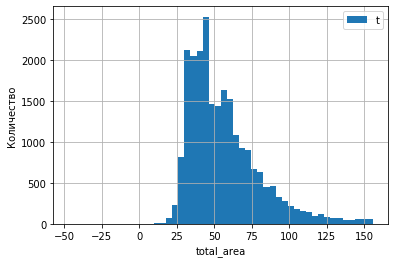

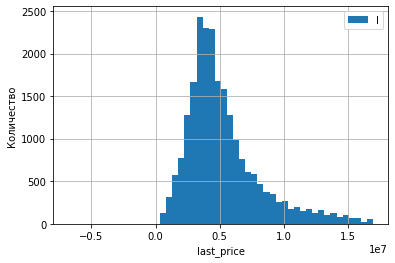

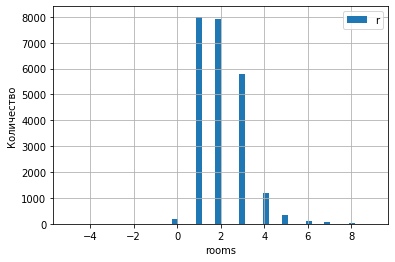

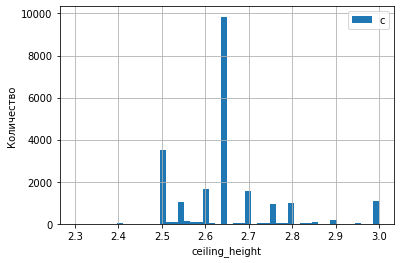

In [70]:
for i in ['total_area','last_price','rooms','ceiling_height']:
    q1 = data[i].quantile(0.25)
    q3 = data[i].quantile(0.75)
    iqr = q3 - q1
    data[i].hist(bins=50,range=(q1-3*iqr,q3+3*iqr))
    plt.xlabel(i)
    plt.ylabel('Количество')
    plt.legend(i)
    plt.show()

На рынке чаще всего встречаются квартиры площадью около 40-50 метров, стоимостью в районе 4 млн., 1 и 2 комнатные с высотой потолков от 2.5 до 2.8 метвров.

<h4>Время продажи</h4>

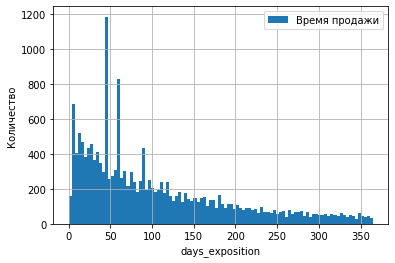

In [104]:
data['days_exposition'].hist(bins=100,range=(0,365),label='Время продажи')
plt.xlabel('days_exposition')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [72]:
data['days_exposition'].describe()

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

<p>Чаще всего квартира продается за 3 месяца.</p>
<p>До 45 дней можно считать, что продажа прошла быстро.</p>
<p>Более 230 дней - слишком долго.</p>
<p></p>
<p>Получается, что норма - от 2 до 6 месяцев.</p>

<h4>Редкие и выбивающиеся значения</h4>

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 29 columns):
total_images            23565 non-null int64
last_price              23565 non-null int64
total_area              23565 non-null int64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null int64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null int64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     18064 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_around3000  

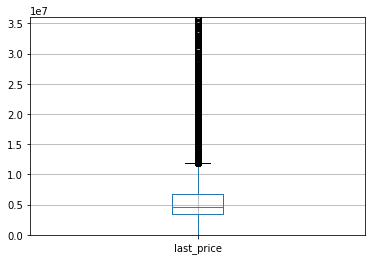

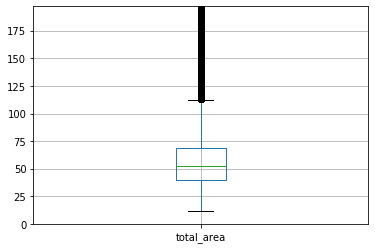

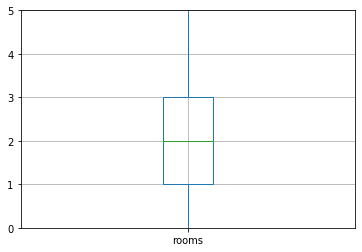

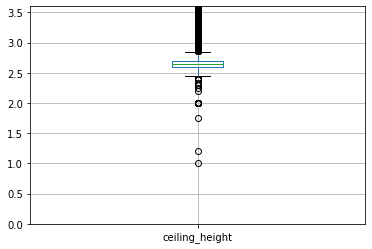

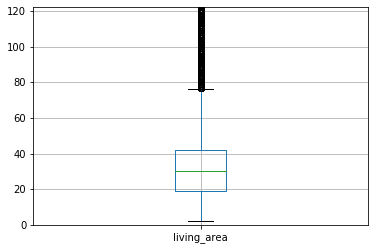

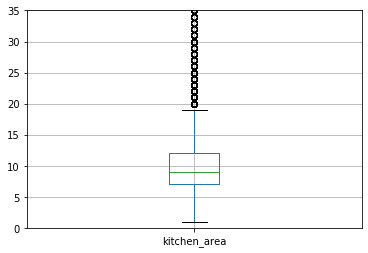

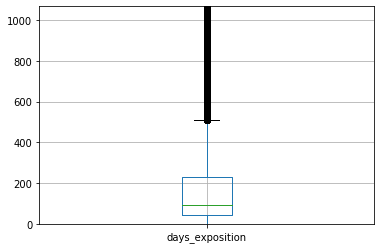

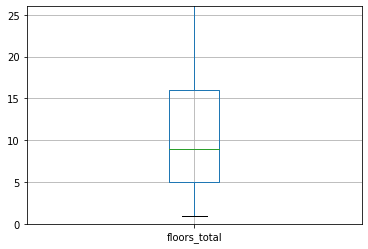

In [74]:
for i in ['last_price','total_area','rooms','ceiling_height','living_area','kitchen_area','days_exposition','floors_total']:
    data.boxplot(column=i)
    plt.ylim(0,data[i].quantile(0.99))
    plt.show()

Ограничили значения по следующим параметрам:
* Цена до 15 млн
* Площадь в диапазоне до 120
* Комнаты от 1 до 3
* Высота потолков от 2.4 до 3
* Жилая площадь до 78
* Площадь кухни до 20
* Время продажи до 550 дней
<p>(Взял значения с небольшим запасом, чтобы осталось больше данных)</p>

In [75]:
clear_data=data.query('total_area<=120 and last_price<=15000000 and 1<=rooms<=3 and 2.40<=ceiling_height<=3 and living_area<=80 and kitchen_area<=20 and days_exposition<=550')

In [76]:
clear_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16301 entries, 1 to 23561
Data columns (total 29 columns):
total_images            16301 non-null int64
last_price              16301 non-null int64
total_area              16301 non-null int64
first_day_exposition    16301 non-null datetime64[ns]
rooms                   16301 non-null int64
ceiling_height          16301 non-null float64
floors_total            16301 non-null float64
living_area             16301 non-null int64
floor                   16301 non-null int64
is_apartment            16301 non-null bool
studio                  16301 non-null bool
open_plan               16301 non-null bool
kitchen_area            16301 non-null int64
balcony                 16301 non-null int64
locality_name           16301 non-null object
airports_nearest        12224 non-null float64
cityCenters_nearest     12239 non-null float64
parks_around3000        12239 non-null float64
parks_nearest           4890 non-null float64
ponds_around3000  

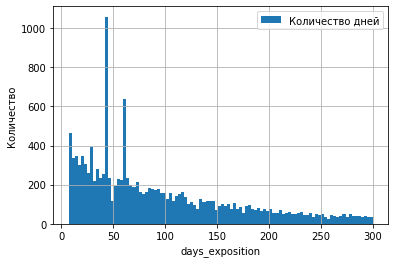

In [77]:
clear_data['days_exposition'].hist(bins=100,range=(7,300),label='Количество дней')
plt.xlabel('days_exposition')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [78]:
clear_data[['total_area','last_price','rooms','floor','ceiling_height','days_exposition']].describe()

,total_area,last_price,rooms,floor,ceiling_height,days_exposition
count,16301.000000,1.630100e+04,16301.000000,16301.000000,16301.000000,16301.000000
mean,50.791792,4.698772e+06,1.820195,6.141525,2.645057,127.908226
std,16.640193,2.257337e+06,0.776416,5.002322,0.106665,124.605274
min,12.000000,4.300000e+05,1.000000,1.000000,2.400000,1.000000
25%,38.000000,3.250000e+06,1.000000,2.000000,2.600000,40.000000
50%,47.000000,4.250000e+06,2.000000,5.000000,2.650000,81.000000
75%,61.000000,5.610000e+06,2.000000,8.000000,2.650000,179.000000
max,120.000000,1.500000e+07,3.000000,33.000000,3.000000,550.000000


После чистки редких и выбивающихся значений ушло 30% данных.

<h4>Зависимость цены от других параметров</h4>

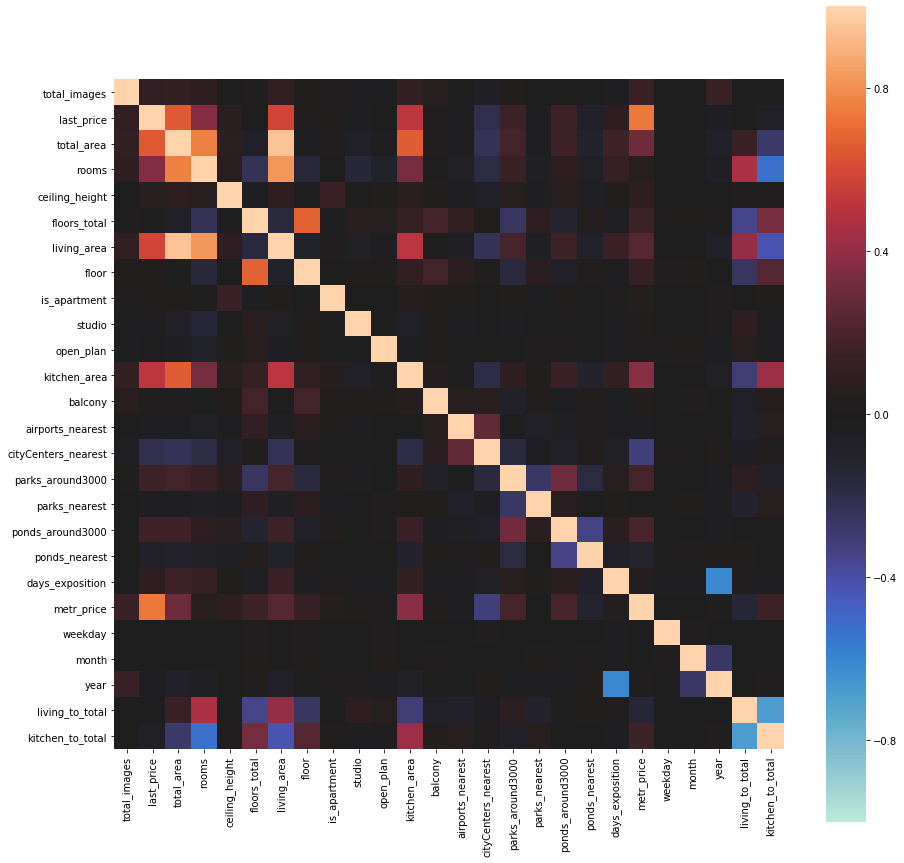

In [79]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),vmin=-1, vmax=1, center= 0,square=True)

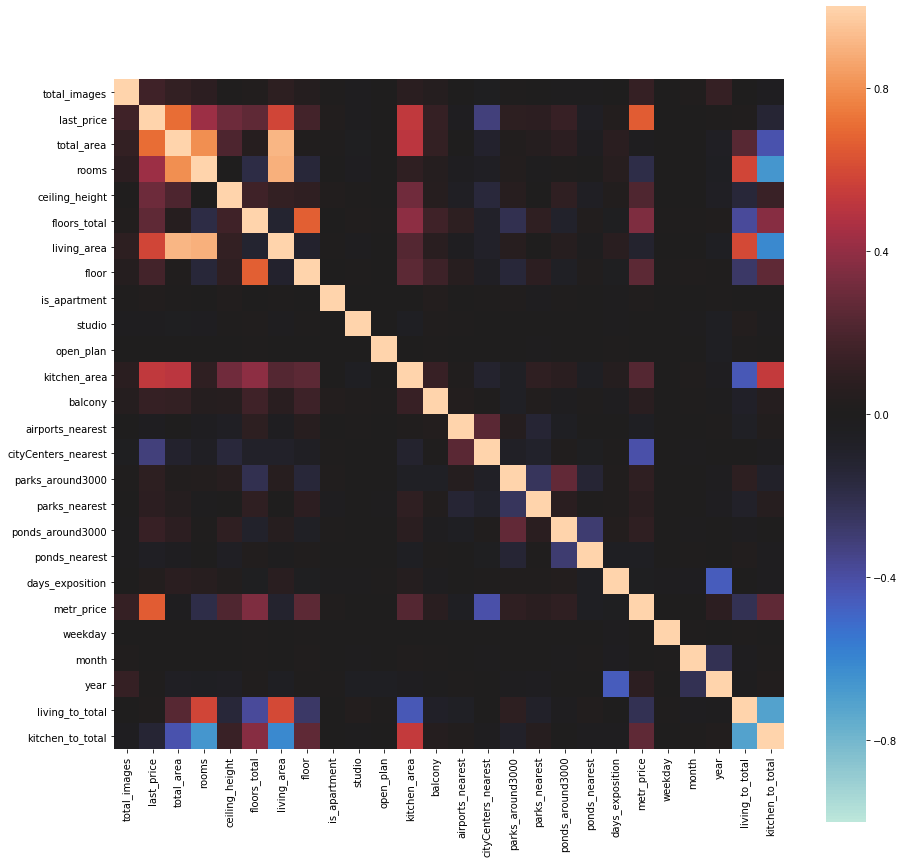

In [80]:
plt.figure(figsize=(15,15))
sns.heatmap(clear_data.corr(),vmin=-1, vmax=1, center= 0,square=True)

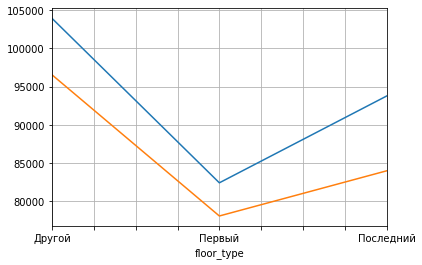

In [81]:
data.groupby('floor_type')['metr_price'].mean().plot(grid=True,label='общие')
clear_data.groupby('floor_type')['metr_price'].mean().plot(grid=True,label='чистые')


Квартиры на первом этаже стоят гораздо дешевле остальных. Чуть более охотнее люди берут квартиры на последних этажах и уже самые ходовые квартиры на других этажах.

In [82]:
for i in ['weekday','month','year']:
    print(i,data['last_price'].corr(data[i]).round(2))
    print()

weekday 0.0

month 0.0

year -0.04



In [83]:
for i in ['weekday','month','year']:
    print(i,clear_data['last_price'].corr(clear_data[i]).round(2))
    print()

weekday -0.0

month 0.0

year 0.01



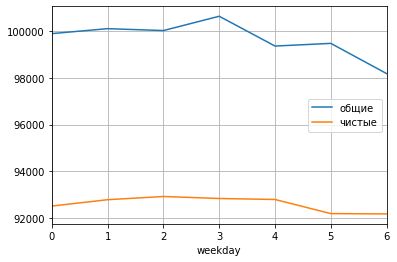

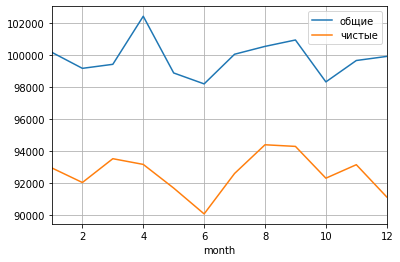

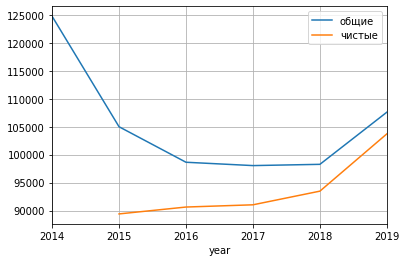

In [84]:
for i in ['weekday','month','year']:
    data.groupby(i)['metr_price'].mean().plot(grid=True,label='общие')
    clear_data.groupby(i)['metr_price'].mean().plot(grid=True,label='чистые')
    plt.legend()
    plt.show()

<p>По графикам видно, что цена объявлений, выложенных в будние дни, гораздо выше, чем в выходные.</p>
<p>Выгоднее всего покупать квартиру в начале лета, дороже всего в августе и сентябре.</p>
<p>Ежегодно цена за квадратный метр среди очищенных данных плавно растёт</p>

<h4>Топ-10 населённых пунктов  с наибольшим числом объявлений</h4>

In [85]:
data['locality_name'].value_counts().head(10)

Санкт-Петербург      15651
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

In [86]:
clear_data['locality_name'].value_counts().head(10)

Санкт-Петербург      10337
посёлок Мурино         457
посёлок Шушары         374
Всеволожск             287
посёлок Парголово      282
Колпино                265
Пушкин                 249
деревня Кудрово        248
Гатчина                235
Выборг                 172
Name: locality_name, dtype: int64

In [87]:
for i in data['locality_name'].value_counts().head(10).index:
    print(i, data[data['locality_name']==i]['metr_price'].mean().round(0))
    print()

Санкт-Петербург 115366.0

посёлок Мурино 86298.0

посёлок Шушары 78943.0

Всеволожск 68985.0

Пушкин 103611.0

Колпино 75735.0

посёлок Парголово 90675.0

Гатчина 69045.0

деревня Кудрово 93002.0

Выборг 58296.0



Среди общих данных дороже всего квартиры в Санкт-Петербурге, дешевле всего в Выборге.

In [88]:
for i in clear_data['locality_name'].value_counts().head(10).index:
    print(i, clear_data[clear_data['locality_name']==i]['metr_price'].mean().round(0))
    print()

Санкт-Петербург 106144.0

посёлок Мурино 86048.0

посёлок Шушары 77951.0

Всеволожск 67062.0

посёлок Парголово 90197.0

Колпино 75835.0

Пушкин 99702.0

деревня Кудрово 93274.0

Гатчина 68553.0

Выборг 57548.0



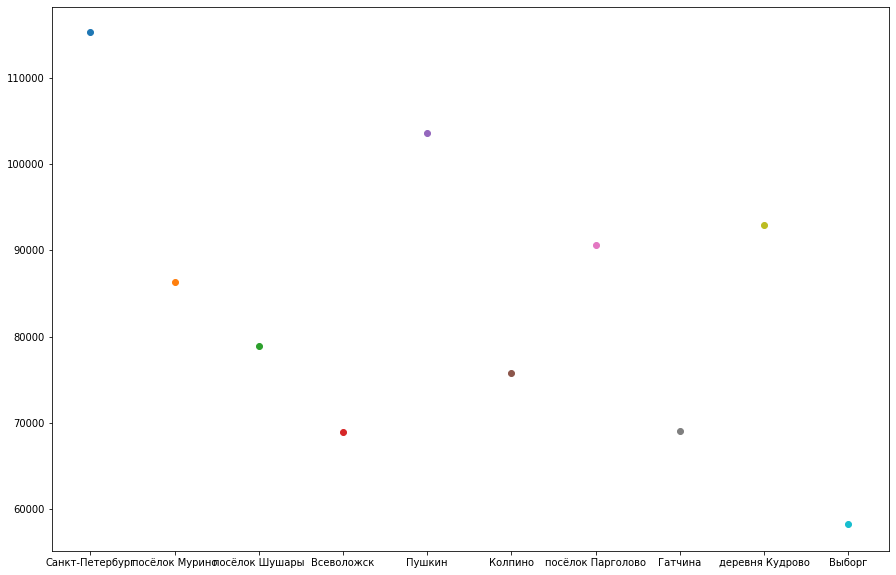

In [89]:
plt.figure(figsize=(15,10))
for i in data['locality_name'].value_counts().head(10).index:
    plt.scatter(i,data[data['locality_name']==i]['metr_price'].mean().round(0))
plt.show()

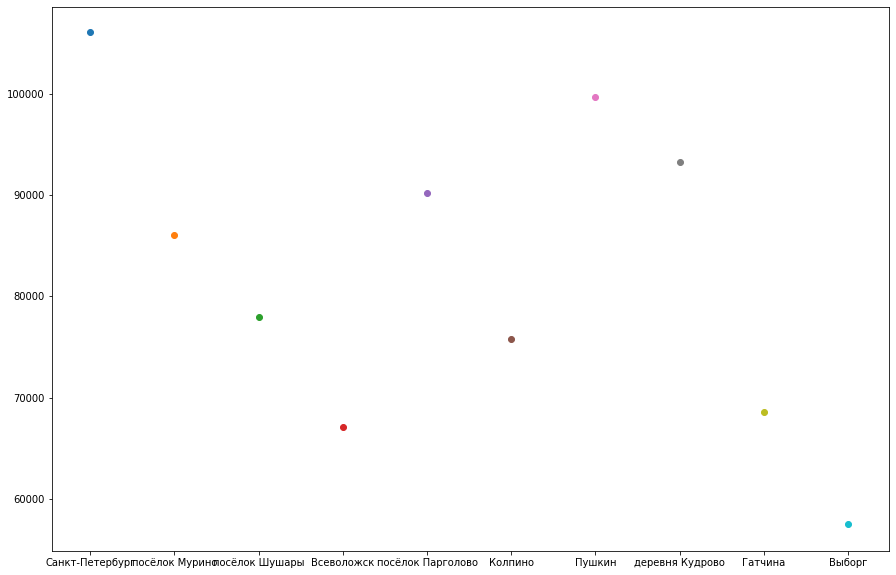

In [90]:
plt.figure(figsize=(15,10))
for i in clear_data['locality_name'].value_counts().head(10).index:
    plt.scatter(i,clear_data[clear_data['locality_name']==i]['metr_price'].mean().round(0))
plt.show()

Из графиков видно, что дороже всего квартиры в Санкт-Петербурге, а дешевле всего в Выборге.

<h4>Центральная зона</h4>

In [91]:
for i in range(len(data)):
    if data.loc[i,'cityCenters_nearest']>0:
        data.loc[i,'cityCenters']=int(data.loc[i,'cityCenters_nearest']/1000)

In [92]:
data['cityCenters'].describe()

count    18064.000000
mean        13.696191
std          8.616500
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         65.000000
Name: cityCenters, dtype: float64

In [93]:
clear_data=clear_data.reset_index()

In [94]:
for i in range(len(clear_data)):
    if clear_data.loc[i,'cityCenters_nearest']>0:
        clear_data.loc[i,'cityCenters']=int(clear_data.loc[i,'cityCenters_nearest']/1000)

In [108]:
for i in range(len(data)):
    if data.loc[i,'cityCenters_nearest']>0:
        data.loc[i,'cityCenters']=int(data.loc[i,'cityCenters_nearest']/1000)

In [95]:
data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters')['metr_price'].mean()

cityCenters
0.0     187716.674419
1.0     166970.441667
2.0     147016.651466
3.0     129939.314885
4.0     137850.312292
5.0     147435.315104
6.0     152774.836170
7.0     141884.238329
8.0     121058.730135
9.0     110513.013081
10.0    112019.243392
11.0    107172.110874
12.0    108812.859696
13.0    107626.993548
14.0    105496.912899
15.0    102348.266764
16.0    100616.417195
17.0     95148.007678
18.0     95309.664740
19.0     96168.865854
20.0    107623.440476
21.0     91947.097436
22.0     89035.294964
23.0     93251.800000
24.0     83176.227273
25.0     91212.723077
26.0     75171.333333
27.0    132115.000000
28.0     81943.700000
29.0     63011.333333
Name: metr_price, dtype: float64

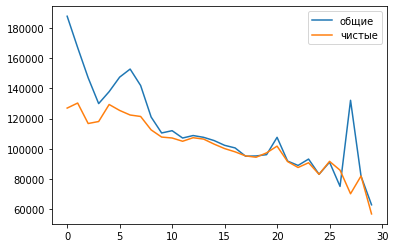

In [96]:
plt.plot(data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters')['metr_price'].mean().index, data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters')['metr_price'].mean(),label='общие')
plt.plot(clear_data[clear_data['locality_name']=='Санкт-Петербург'].groupby('cityCenters')['metr_price'].mean().index, clear_data[clear_data['locality_name']=='Санкт-Петербург'].groupby('cityCenters')['metr_price'].mean(),label='чистые')
plt.legend()
plt.show()

<p>Из графиков видно, что центр заканчивается на границе около 7 километров.</p>

<h4>Центральная зона</h4>

In [97]:
centr_data=clear_data.query("locality_name=='Санкт-Петербург' and cityCenters<=7")
centr_data.head(5)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_nearest,days_exposition,metr_price,weekday,month,year,floor_type,living_to_total,kitchen_to_total,cityCenters
15,24,8,6500000,97,2015-10-31,2,2.65,3.0,46,1,...,124.0,265.0,67010,5,10,2015,Первый,0.474227,0.195876,2.0
66,94,3,3500000,29,2019-04-26,1,2.50,5.0,15,2,...,NaN,4.0,120689,4,4,2019,Другой,0.517241,0.172414,7.0
73,111,4,4590000,40,2017-05-29,1,2.65,6.0,18,1,...,NaN,31.0,114750,0,5,2017,Первый,0.450000,0.250000,6.0
88,138,8,4800000,40,2017-11-18,2,2.65,3.0,29,2,...,729.0,80.0,120000,5,11,2017,Другой,0.725000,0.150000,2.0
91,143,9,2990000,30,2016-06-08,1,2.50,9.0,20,9,...,332.0,60.0,99666,2,6,2016,Последний,0.666667,0.166667,6.0


In [98]:
piter_data=clear_data.query("locality_name=='Санкт-Петербург'")
piter_data.head(5)

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_nearest,days_exposition,metr_price,weekday,month,year,floor_type,living_to_total,kitchen_to_total,cityCenters
4,9,18,5400000,61,2017-02-26,3,2.50,9.0,43,7,...,NaN,289.0,88524,6,2,2017,Другой,0.704918,0.098361,15.0
5,10,5,5050000,39,2017-11-16,1,2.67,12.0,20,3,...,553.0,137.0,129487,3,11,2017,Другой,0.512821,0.205128,13.0
10,15,16,4650000,39,2017-11-18,1,2.65,14.0,20,5,...,296.0,19.0,119230,5,11,2017,Другой,0.512821,0.179487,14.0
11,18,8,3250000,31,2017-01-27,1,2.50,5.0,19,2,...,NaN,168.0,104838,4,1,2017,Другой,0.612903,0.161290,10.0
13,21,13,3200000,31,2018-03-14,1,2.65,5.0,16,2,...,NaN,310.0,103225,2,3,2018,Другой,0.516129,0.161290,9.0


Создал два среза: центра питера и весь питер.

In [99]:
centr_data[['total_area','last_price','rooms','ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,1382.000000,1.382000e+03,1382.000000,1382.000000
mean,60.053546,7.274354e+06,2.057164,2.715673
std,19.402890,2.660874e+06,0.763241,0.141352
min,12.000000,1.600000e+06,1.000000,2.400000
25%,45.000000,5.300000e+06,1.000000,2.650000
50%,58.000000,6.750000e+06,2.000000,2.650000
75%,73.750000,8.750000e+06,3.000000,2.800000
max,120.000000,1.500000e+07,3.000000,3.000000


In [100]:
piter_data[['total_area','last_price','rooms','ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,10337.000000,1.033700e+04,10337.000000,10337.000000
mean,52.014995,5.490949e+06,1.851698,2.651081
std,17.267554,2.233357e+06,0.786253,0.112852
min,12.000000,1.190000e+06,1.000000,2.400000
25%,39.000000,3.950000e+06,1.000000,2.600000
50%,48.000000,4.899000e+06,2.000000,2.650000
75%,62.000000,6.450000e+06,2.000000,2.650000
max,120.000000,1.500000e+07,3.000000,3.000000


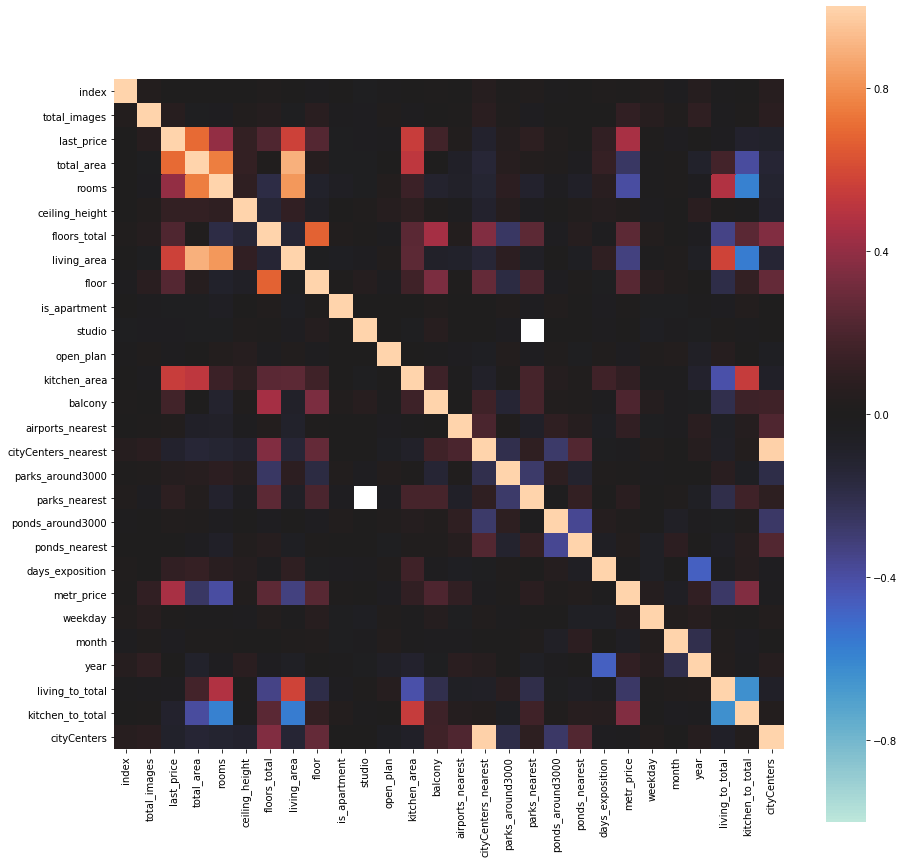

In [101]:
plt.figure(figsize=(15,15))
sns.heatmap(centr_data.corr(),vmin=-1, vmax=1, center= 0,square=True)

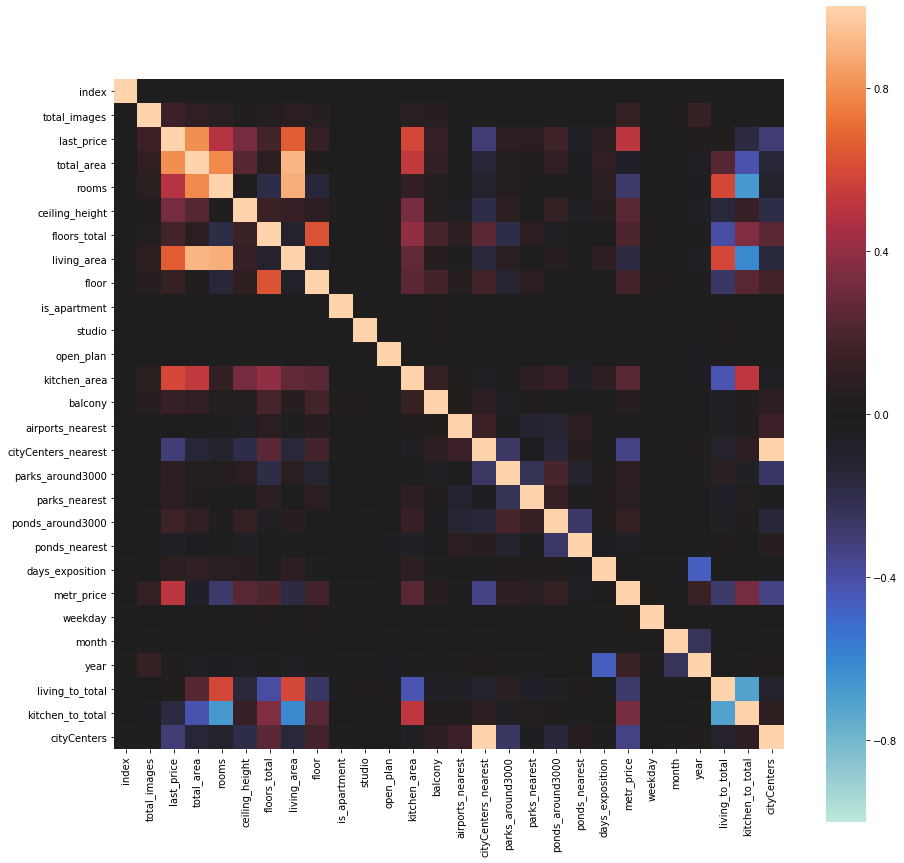

In [102]:
plt.figure(figsize=(15,15))
sns.heatmap(piter_data.corr(),vmin=-1, vmax=1, center= 0,square=True)

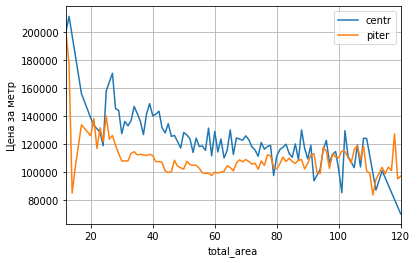

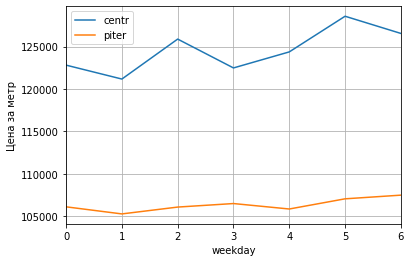

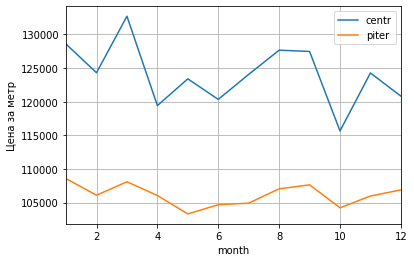

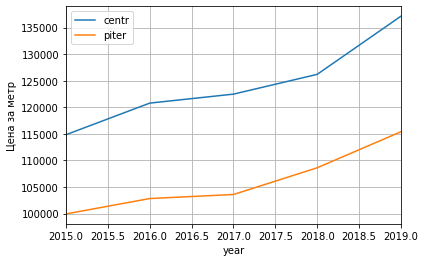

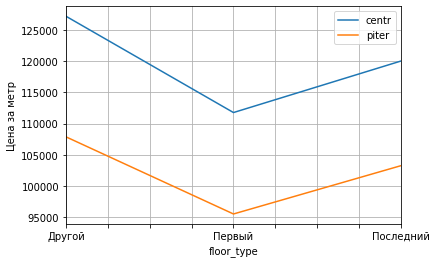

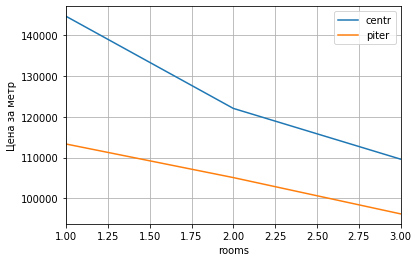

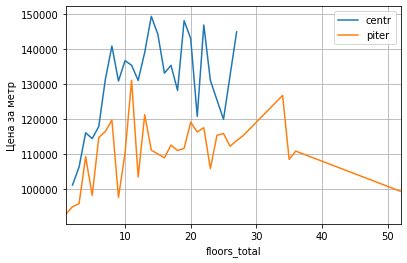

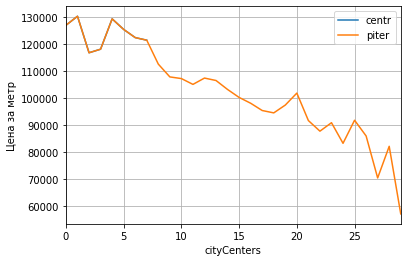

In [110]:
for i in ['total_area','weekday','month','year','floor_type','rooms','floors_total']:
    centr_data.groupby(i)['metr_price'].mean().plot(grid=True,label='centr')
    plt.ylabel('Цена за метр')
    piter_data.groupby(i)['metr_price'].mean().plot(grid=True,label='piter')
    plt.ylabel('Цена за метр')
    plt.legend()
    plt.show()

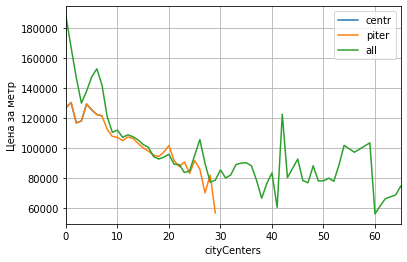

In [111]:
centr_data.groupby('cityCenters')['metr_price'].mean().plot(grid=True,label='centr')
plt.ylabel('Цена за метр')
piter_data.groupby('cityCenters')['metr_price'].mean().plot(grid=True,label='piter')
plt.ylabel('Цена за метр')
data.groupby('cityCenters')['metr_price'].mean().plot(grid=True,label='all')
plt.ylabel('Цена за метр')
plt.legend()
plt.show()

- Цена квартир в центре значительно выше, чем в остальной часте города. 
- При площади от 100 метров цена начинает быть соизмеримой.
- В центре объявления о продаже выложенные в выходные, гораздо дороже, чем в будние дни. 
- Выгоднее всего продавать квартиру в центре в марте, а покупать в октябре.
- С каждым годом цена в центре растёт быстрее, чем в остальном городе.
- Зависимость от этажа почти одинаковая, люди охотнее берут не первый и не последний этажи.
- С увеличем числа комнат разница в цене между цетром и всем городом значительно уменьшается.
- В центре города почти нет высокоэтажек.


### Шаг 5. Общий вывод

- Нам удалось очистить данные от артефактов и заполнить множество пропусков. Но не все столбцы можно заполнить исходя из логики или средних значений, поэтому некоторые пропуски мы оставили.
- Исходя из диаграмм размаха выявили нормальные значения и удалили выпадающие.
- Смогли посчитать и добавить новые нужные нам параметры, которые пригодились нам в дальнейшем для анализа.
- Построили тепловую карту по корреляции всей таблици, увидили некотороые зависимости.
- Добавили кучу графиков, которые позволили нам оценить зависимость цены от множества факторов.
- Выделили центр города и сравнили данные с остальным городов, увидили значительную разницу

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. 
- [x]  выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод